# Final Project
Class: CSPB 3202
Author: Sara Rhoades
Semester: Summer 2024

In [1]:
from collections import namedtuple
partition = namedtuple("partition", ["type", "subtype"])
from IPython import display
import gym 
from gym.spaces.discrete import Discrete
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

*Short overview of what your project is about (e.g. you're building /testing certain RL models in certain environments; yes, you can test your algorithm in more than 1 environment if your goal is to test an algorithm(s) performances in different settings)*

Three agents were build and compared against each other for a classical control problem.

## Approach
*explain your environment, your choice of model(s), the methods and purpose of testing and experiments, and explain any troubleshooting required.*

The approach is split into three sections - about the enviornment, about the agents, and training the agents in the environment.

### Set up and Learn about the environment

Setup of this environment requires additional installs (pip install gymnasium[classic-control]) in additional to those described in RLenvsetup.md which was provided with the project and repeated in the appendix.

From the documentation of the environment: "The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with continous actions." (ref 1).

In [2]:
# Chosen problem
env = gym.make("MountainCar-v0")

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis (in meters) and the velocity of the car (in m/s). X-position is limited to between -1.2 and +0.6 meters, with velocity limited to between -0.07 and +0.07 m/s.

In [3]:
# Our starting state
env.reset()

(array([-0.4033666,  0.       ], dtype=float32), {})

There are three discrete deterministic actions that the agent can take:

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

In [4]:
# Our possible actions
env.action_space

Discrete(3)

### Set up the Agent

In [26]:
class Agent:
    def __init__(self,alpha=0.01,epsilon=0.5,decay=0.0):
        self.env = gym.make("MountainCar-v0")
        self.state = self.env.reset()
        self.weights = {}
        self.rewards = []
        self.steps = []
        self.policy = []
        self.alpha = alpha
        self.epsilon = epsilon
        self.decay = decay
        self.discount = 1.0
        self.validActions = [0,1,2]
        
    # Getters and Setters----------------------------
        
    def getWeights(self):
        return self.weights
    
    def setWeights(self,feature,weight):
        self.weights[feature] = weight
        
    def getRewards(self):
        return self.rewards
    
    def setRewards(self,total):
        self.rewards = total
        
    def getSteps(self):
        return self.steps
    
    def setSteps(self,step):
        self.steps = step
        
    def getPolicy(self, state):
        return self.computeActionFromQValues(state)
    
    def setPolicy(self, policy):
        self.policy = policy
    
    def getLearningRate(self):
        return self.alpha
    
    def setLearningRate(self,alpha):
        self.alpha = alpha
        
    def getExplorationRate(self):
        return self.epsilon
    
    def setExplorationRate(self,epsilon):
        self.epsilon = epsilon
        
    def getDecayRate(self):
        return self.decay
    
    def setDecayRate(self,decay):
        self.decay = decay
        
    def getDiscount(self):
        return self.discount
    
    def setDiscount(self,discount):
        self.discount = discount

    def getValue(self, state):
        return self.computeValueFromQValues(state)
    
    def setValue(self, state, action, value):
        self.qValue[(state,action)] = value
        return
    
    # Functions--------------------------------------
        
    def select_action(self, state, action):  
        return action
    
    def update(self, state, action, nextState, reward):
        return

    def play_episode(self, env):
        total_reward = 0.0
        state = env.reset()
        action = random.choice(self.validActions)
        steps = 0
        actions = []
        isInit = 1
        while True:
            if isInit:
                state = state[0]
                isInit = 0
            action = self.select_action(state, action)
            new_state, reward, is_done, _, _ = env.step(action)
            self.update(state, action, new_state, reward)
            total_reward += reward
            steps +=1
            actions.append(action)
            if is_done:
                break
            state = new_state
        return total_reward, steps, actions
    
    def repeat(self,n_sample):
        rewards =[]
        steps=[]
        policy = []
        for i in range(n_sample):
            reward, step, actions = self.play_episode(self.env)
            rewards.append(reward)
            steps.append(step)
            policy.append(actions)
        self.setRewards(rewards)
        self.setSteps(steps)
        self.setPolicy(policy)
        
# Class Extentions-----------------------------------
        
class RandomAgent(Agent):
    # This agent acts randomly
    def select_action(self,state,action):  
        return env.action_space.sample()
    
class ReflexAgent(Agent):   
    # This agent has a build in (hard-coded) set of rules (policy)
    def select_action(self, state, action):  
        if state[0] < 0:
            if state[1] < 0:
                action = 1
            else:
                action = 2
        else:
            if state[1] < 0:
                action = 0
            else:
                action = 2
        return action 
            
class LearningAgent(Agent): 
    # This agent learns it's own policy from experience
    def select_action(self, state, action):
        # Exploration
        if (random.random()<self.getExplorationRate()):
            # Act Randomly
            action = env.action_space.sample()
        # Exploitation
        else:
            # Chose action from State using Policy
            action = self.computeActionFromQValues(state)
        return action
    
    def computeValueFromQValues(self, state):
        """
          Returns max_action Q(state,action)
          where the max is over legal actions.  Note that if
          there are no legal actions, which is the case at the
          terminal state, you should return a value of 0.0.
        """
        (bestAction,bestValue) = self.computeBestFromQValues(state)
        return bestValue

    def computeActionFromQValues(self, state):
        """
          Compute the best action to take in a state.  Note that if there
          are no legal actions, which is the case at the terminal state,
          you should return None.
        """
        (bestAction,bestValue) = self.computeBestFromQValues(state)
        return bestAction
    
    def computeBestFromQValues(self, state):
        bestAction = None
        bestValue = float('-inf')
        for action in self.validActions:
            # Use approx RL to get values
            value = self.getQValue(state,action)
            if (value > bestValue):
                bestAction = action
                bestValue = value
            # If exact same value, break ties randomly for better behavior
            elif (value == bestValue):
                if (random.random()<0.5):
                    bestAction = action
                    bestValue = value
        return (bestAction,bestValue)
    
    def getFeatures(self, state, action):
        # X-Position, X-Velocity, X-acceleration
        features = {}
        features["pos"] = state[0]
        features["vel"] = state[1]
        features["acc"] = action
        return features

    def getQValue(self, state, action):
        """
          Should return Q(state,action) = w * featureVector
          where * is the dotProduct operator
        """
        Q = 0.0
        features = self.getFeatures(state,action)
        weights = self.getWeights()
        for feature in features:
            if feature in weights.keys():
                weight = weights[feature]
            else:
                weight = 0.0
            Q = Q + weight*features[feature]
        return Q
    
    def update(self, state, action, nextState, reward):
        """
           Should update your weights based on transition
        """
        oldValue = self.getQValue(state,action)
        nextBestValue = self.getValue(nextState)
        newValue = reward + (self.getDiscount()*nextBestValue) - oldValue
        
        features = self.getFeatures(state,action)
        weights = self.getWeights()
        for feature in features:
            if feature in weights.keys():
                oldWeight = weights[feature]
            else:
                oldWeight = 0.0
            updateValue = oldWeight + self.getLearningRate()*(newValue)*features[feature]
            self.setWeights(feature,updateValue)
            
        self.setExplorationRate(max(0.1,self.getExplorationRate()-self.getDecayRate()))
        return

### Teach the Agents

In [6]:
numberGames = 100

In [7]:
tic = time.perf_counter()
rda = RandomAgent()
rda.repeat(numberGames)
rewards1 = rda.rewards
toc = time.perf_counter()
print(f"Trained Random Agent in {toc - tic:0.4f} seconds")

Trained Random Agent in 137.2418 seconds


In [8]:
tic = time.perf_counter()
ra = ReflexAgent()
ra.repeat(numberGames)
rewards2 = ra.rewards
toc = time.perf_counter()
print(f"Trained Reflex Agent in {toc - tic:0.4f} seconds")

Trained Reflex Agent in 0.5886 seconds


In [27]:
tic = time.perf_counter()
la = LearningAgent()
la.repeat(numberGames)
rewards3 = la.rewards
toc = time.perf_counter()
print(f"Trained Learning Agent in {toc - tic:0.4f} seconds")

Trained Learning Agent in 18.9603 seconds


In [28]:
tic = time.perf_counter()
lat = LearningAgent(0.01,0.5,0.001)
lat.repeat(numberGames)
rewards4 = lat.rewards
toc = time.perf_counter()
print(f"Trained Learning Agent in {toc - tic:0.4f} seconds")

Trained Learning Agent in 11.5206 seconds


## Results
*show the result and interpretation of your experiment. Any iterative improvements summary.*

-43360.1 46499.43283191742 -2263.0


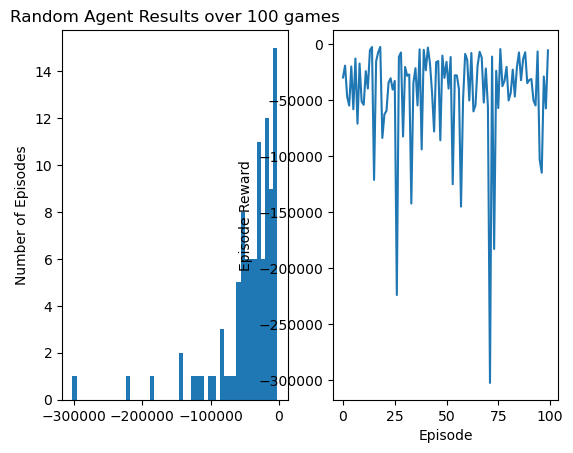

In [29]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards1,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Random Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards1)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print(np.mean(rewards1), np.std(rewards1), max(rewards1))

-189.0 27.248486196484386 -131.0


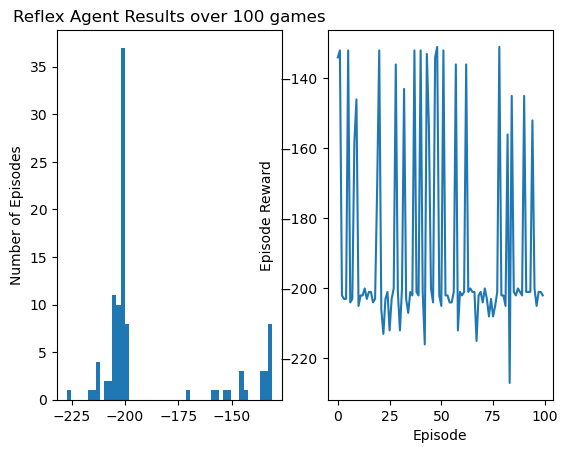

In [30]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards2,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Reflex Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards2)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print(np.mean(rewards2), np.std(rewards2), max(rewards2))

-4156.63 4297.258022634898 -673.0


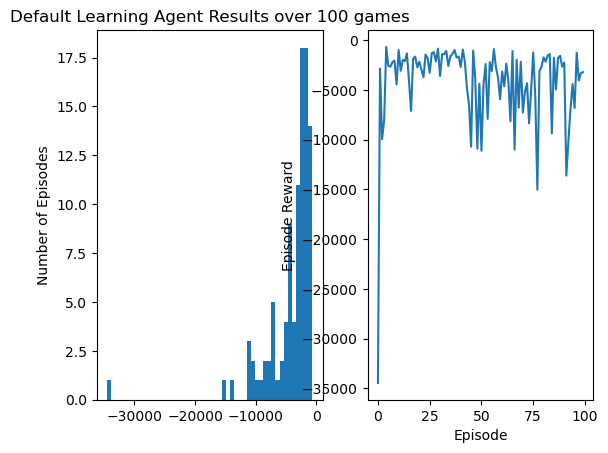

In [31]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards3,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Default Learning Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards3)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print(np.mean(rewards3), np.std(rewards3), max(rewards3))

-2626.64 4190.930115189229 -524.0


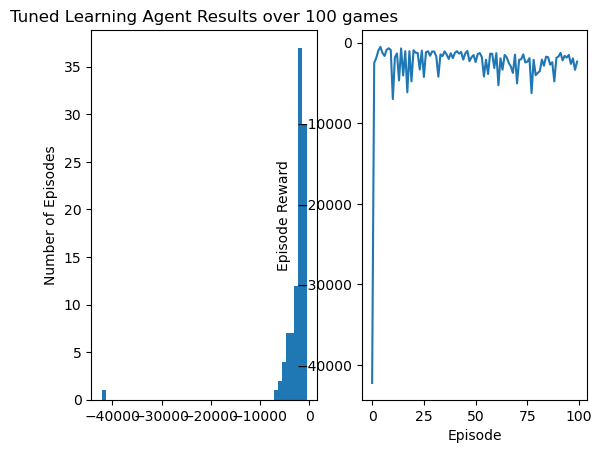

In [32]:
fig, axs = plt.subplots(1, 2)

axs[0].hist(rewards4,bins=50)
axs[0].set(ylabel='Number of Episodes')
axs[0].set_title("Tuned Learning Agent Results over "+ str(numberGames) +" games")

axs[1].plot(rewards4)
axs[1].set(xlabel='Episode', ylabel='Episode Reward')

print(np.mean(rewards4), np.std(rewards4), max(rewards4))

## Conclusions

*Conclusion, discussion, reflection, or suggestions for improvements or ideas.*

## Reference:

Git Location:

Video Location:

1. Farama Foundation. 2023. https://gymnasium.farama.org/environments/classic_control/mountain_car/
2. CSPB 3202. Intro to Gym/Gymnasium.
3. Farama Foundation. 2023. https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/#sphx-glr-tutorials-training-agents-blackjack-tutorial-py
4. Geir Arne Hjelle. 2020. https://realpython.com/python-timer/#python-timers

## Appendix

### Setup Instructions [Ref 2]

The commands valid as of 04-10-2020

This additional package assumes you have other standard dependencies installed. If not and it causes error in the middle, please follow the message to troubleshoot or reach out to us for help.

This is for a local machine in a linux server, and has not been tested in the other system. If you use a VM service such as google colab and encounter a problem, please reach out to us.

Unless your project involves computer vision tasks and neural network models, you may not need a gpu machine, so you can still try in your local machine even if there is no (nvidia or compatible) gpu.

```
pip install -U pip

pip install -U torch torchvision ## caution: this is for linux. Windows' pip won't work and need conda: see https://pytorch.org/get-started/locally/

pip install gym

pip install atari-py

pip install opencv-python

pip install -U scipy

pip install -U tensorflow-gpu ## you won't need it if you don't have a gpu or in a colab environment where tensorflow-gpu is already available.

pip install -U tensorboard

```